In [1]:
from netCDF4 import Dataset
import numpy as np
from numpy import sin, cos, tan, arctan, deg2rad, rad2deg
import matplotlib.pyplot as plt
from scipy import signal
from functions import *
%matplotlib inline

In [5]:
d_deg = 0.025
Radius = 6.371e6
center_lon_inDeg, center_lat_inDeg = 0.0, -70.0

center_lon, center_lat = deg2rad(center_lon_inDeg), deg2rad(center_lat_inDeg)

xtolerance = 10
ytolerance = 5

x_start_indeg = -xtolerance - center_lon_inDeg
x_end_indeg = xtolerance + center_lon_inDeg
y_start_indeg = center_lat_inDeg - ytolerance
y_end_indeg = center_lat_inDeg + ytolerance

x_start = deg2rad(x_start_indeg)
x_end = deg2rad(x_end_indeg)
y_start = deg2rad(y_start_indeg)
y_end = deg2rad(y_end_indeg)

d_deg_inRad = deg2rad(d_deg)

x_range = x_end - x_start
y_range = y_end - y_start
print(y_range)
print('lat range', rad2deg(y_start), rad2deg(y_end))

ylen = int(y_range//d_deg_inRad)
xlen = int(x_range//d_deg_inRad)

print('ylen, xlen' , ylen, xlen)

lat = np.linspace(y_start, y_end, ylen)
lon = np.linspace(x_start, x_end, xlen)

LON, LAT = np.meshgrid(lon, lat)
dlat = lat[1] - lat[0]
dlon = lon[1] - lon[0]

dX = Radius * cos(LAT)*dlon
dY = np.full((ylen, xlen), Radius * dlat)
UAREA = dX*dY

0.17453292519943298
lat range -75.0 -65.0
ylen, xlen 400 799


-1.2217304763960306
1.0


/local_scratch/16126012/ipykernel_10557/3322292739.py:12: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(X/1e3, Y/1e3, kernel)


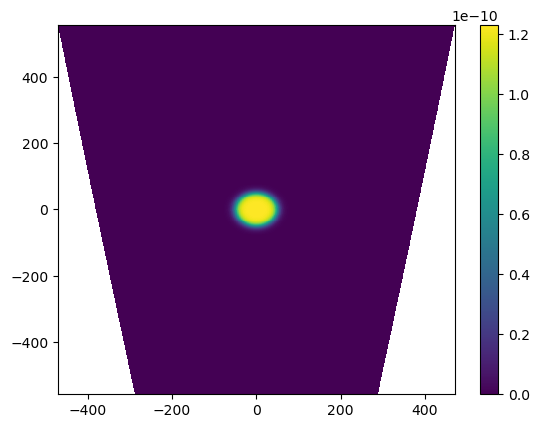

In [6]:
ell = 100e3

r = getGeodesicDistFromLonLat(center_lon, center_lat, LON, LAT, Radius)
X, Y = getXYlengthsFromLonLat(center_lon, center_lat, LON, LAT, Radius)
kernel = getKernel(r/1e3, ell/1e3, UAREA)
print(center_lat)




#plt.pcolormesh(rad2deg(lon), rad2deg(lat), kernel)
plt.pcolormesh(X/1e3, Y/1e3, kernel)
plt.colorbar()
print(np.sum(kernel*UAREA))

# Definition of functions

In [7]:
a = 5
b = 5

ka = 1
kb = 1

c = 1
d = 1

kc = 2
kd = 2

X_range_meters = np.array(xlen*[X[:,-1] - X[:,0] + dX[:,0]]).T
Y_range_meters = np.array(ylen*[Y[-1,:] - Y[0,:] + dY[0,:]])
f1 = a*np.sin(ka * 2*np.pi*Y/Y_range_meters) + c*np.cos(kc * 2*np.pi*X/X_range_meters)
f2 = c*np.cos(kb * 2*np.pi*X/X_range_meters) + d*np.sin(kd * 2*np.pi*Y/Y_range_meters)


### 
#### this one is using  power law

f1 = getNoise(-3, xlen, ylen, d_deg, d_deg)
f2 = getNoise(-3, xlen, ylen, d_deg, d_deg)    


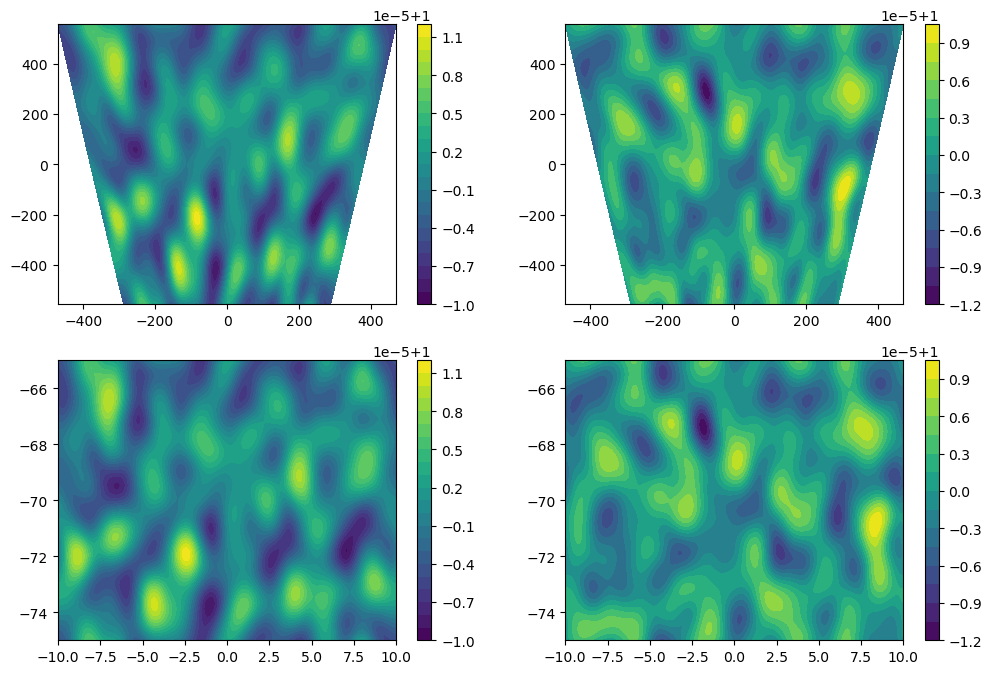

In [8]:
nlevels = 20

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
m = ax[0,0].contourf(X/1e3, Y/1e3, f1, levels=nlevels)
plt.colorbar(m, ax=ax[0, 0])

m = ax[0,1].contourf(X/1e3, Y/1e3, f2, levels=nlevels)
plt.colorbar(m, ax=ax[0, 1])

m = ax[1,0].contourf(rad2deg(lon), rad2deg(lat), f1, levels=nlevels)
plt.colorbar(m, ax=ax[1, 0])

m = ax[1,1].contourf(rad2deg(lon), rad2deg(lat), f2, levels=nlevels)
plt.colorbar(m, ax=ax[1, 1])

0.9750419688632198


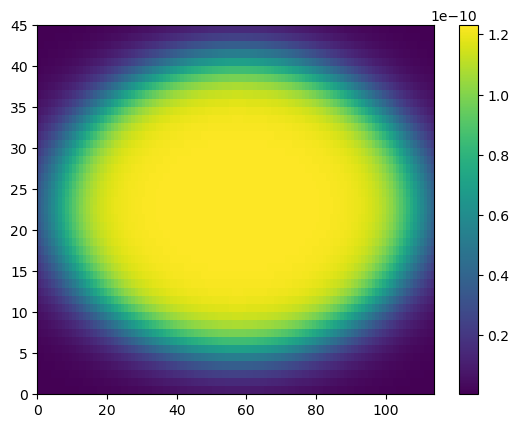

In [9]:
midId_x = int(xlen//2)
midId_y = int(ylen//2)


startId_x = np.argmin(abs(X[midId_y,:] - (-ell/2)))- 5
endId_x = np.argmin(abs(X[midId_y,:] - (ell/2)))+ 5

startId_y = np.argmin(abs(Y[:, midId_x] - (-ell/2)))- 5
endId_y = np.argmin(abs(Y[:, midId_x] - (ell/2)))+ 5

ker =  kernel[startId_y:endId_y, startId_x:endId_x]
uarea =  UAREA[startId_y:endId_y, startId_x:endId_x]

plt.pcolormesh(ker)
plt.colorbar()

print(np.sum(ker*uarea))

In [10]:
# f1bar = signal.convolve2d(f1, ker*uarea, mode='same', boundary='wrap')
# f2bar = signal.convolve2d(f2, ker*uarea, mode='same', boundary='wrap')
# f1f2bar = signal.convolve2d(f1*f2, ker*uarea, mode='same', boundary='wrap')

field_list = np.stack((f1, f2, f1*f2), axis=0)
print(np.shape(field_list))
fieldBar_list = getFilteredField(ell, field_list, UAREA, LON, LAT, Radius)

(3, 400, 799)


In [11]:
f1bar = fieldBar_list[0,:,:]
f2bar = fieldBar_list[1,:,:]
f1f2bar = fieldBar_list[2,:,:]

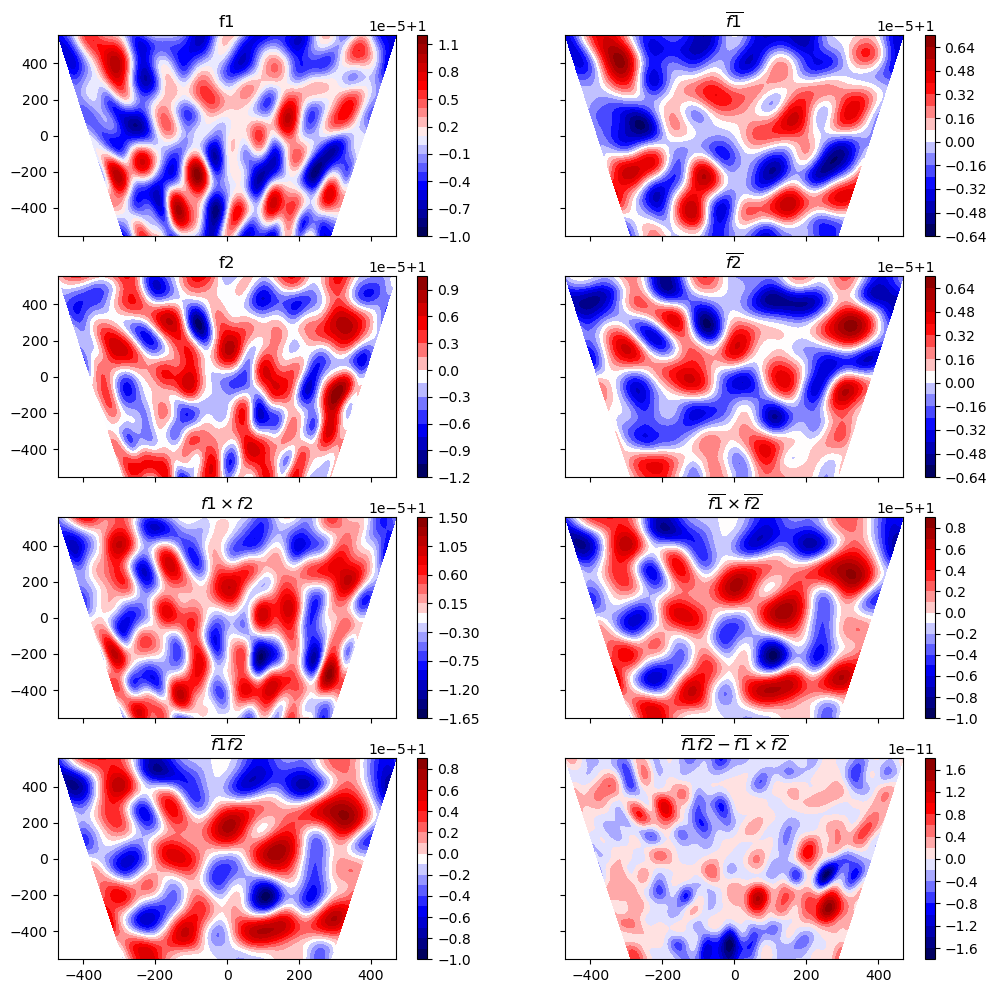

In [12]:
cmap = plt.get_cmap('seismic')

nlevels = 20

fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(12,12), sharex=True, sharey=True)
m = ax[0,0].contourf(X/1e3, Y/1e3, f1, cmap = cmap, levels=nlevels)
ax[0,0].set_title('f1')
plt.colorbar(m, ax=ax[0, 0])

m = ax[0,1].contourf(X/1e3, Y/1e3, f1bar, cmap = cmap, levels=nlevels)
ax[0,1].set_title(r'$\overline{f1}$')
plt.colorbar(m, ax=ax[0, 1])

m = ax[1,0].contourf(X/1e3, Y/1e3, f2, cmap = cmap, levels=nlevels)
ax[1,0].set_title('f2')
plt.colorbar(m, ax=ax[1, 0])

m = ax[1,1].contourf(X/1e3, Y/1e3, f2bar, cmap = cmap, levels=nlevels)
ax[1,1].set_title(r'$\overline{f2}$')
plt.colorbar(m, ax=ax[1, 1])

m = ax[2,0].contourf(X/1e3, Y/1e3, f1*f2, cmap = cmap, levels=nlevels)
ax[2,0].set_title(r'$f1\times f2$')
plt.colorbar(m, ax=ax[2, 0])

m = ax[2,1].contourf(X/1e3, Y/1e3, f1bar * f2bar, cmap = cmap, levels=nlevels)
ax[2,1].set_title(r'$\overline{f1}\times\overline{f2}$')
plt.colorbar(m, ax=ax[2, 1])


m = ax[3,0].contourf(X/1e3, Y/1e3, f1f2bar, cmap = cmap, levels=nlevels)
ax[3,0].set_title(r'$\overline{f1f2}$')
plt.colorbar(m, ax=ax[3, 0])

m = ax[3,1].contourf(X/1e3, Y/1e3, f1f2bar - f1bar * f2bar, cmap = cmap, levels=nlevels)
ax[3,1].set_title(r'$\overline{f1f2} - \overline{f1}\times\overline{f2}$')
plt.colorbar(m, ax=ax[3, 1])

In [13]:
def GetGradient_POP2(Array2D, DX, DY):
    p = -1
    m = 1
    x = 1
    y = 0
    topRight = 0.25*(Array2D + np.roll(Array2D, p, axis=x) +\
               np.roll(Array2D, (p,p), axis=(y,x)) +\
               np.roll(Array2D, p, axis=y))
    
    topLeft = 0.25*(Array2D + np.roll(Array2D, p, axis=y) +\
               np.roll(Array2D, (p,m), axis=(y,x)) +\
               np.roll(Array2D, m, axis=x))
    
    bottomRight = 0.25*(Array2D + np.roll(Array2D, p, axis=x) +\
               np.roll(Array2D, (m,p), axis=(y,x)) +\
               np.roll(Array2D, m, axis=y))
    
    bottomLeft = 0.25*(Array2D + np.roll(Array2D, m, axis=x) +\
               np.roll(Array2D, (m,m), axis=(y,x)) +\
               np.roll(Array2D, m, axis=y))
    
    gradx = 0.5*(topRight + bottomRight - topLeft - bottomLeft)/DX
    grady = 0.5*(topRight + topLeft - bottomRight - bottomLeft)/DY
    
    return gradx, grady

def GetGradient_order(phi, DX, DY):
    n=4
    coeffs = np.array([1./280, -4./105, 1./5, -4./5, 0, 4./5, -1./5, 4./105, -1./280], dtype=float)
    

    dx_phi = np.zeros(phi.shape, dtype=float)
    dy_phi = np.zeros(phi.shape, dtype=float)
    
    
    for i in range(-n, n+1):
        dx_phi += np.roll(phi, i, axis = 1) * -coeffs[n+i]
        dy_phi += np.roll(phi, i, axis = 0) * -coeffs[n+i]
        #print(i, coeffs[n+i])
    
    dx_phi = dx_phi/DX
    dy_phi = dy_phi/DY
    
    return dx_phi, dy_phi

def GetGradient(phi, DX, DY):
    dx_phi, dy_phi = GetGradient_POP2(phi, DX, DY)#, UAREA)     
    return dx_phi, dy_phi


def getModelVal(f1_bar, f2_bar, DX, DY, ell):
    C_2 = 2*(ell**2)/8
    dx_f1, dy_f1 = GetGradient(f1_bar, DX, DY)
    dx_f2, dy_f2 = GetGradient(f2_bar, DX, DY)

    model = dx_f1 * dx_f2 +\
            dy_f1 * dy_f2

    model *= C_2

    return model

def getModel2Val(f1_bar, f2_bar, DX, DY, ell):
    C_2 = 0.125
    dx_f1, dy_f1 = GetGradient(f1_bar, DX, DY)
    dx_f2, dy_f2 = GetGradient(f2_bar, DX, DY)

    model = dx_f1 * dx_f2 +\
            dy_f1 * dy_f2
    
    model *= (1/2 * (ell)**2 * C_2)

    return model

In [14]:
truth = f1f2bar - f1bar*f2bar # f1f2bar-f1bar*f2bar
model = getModelVal(f1bar, f2bar, dX, dY, ell)
model2 = getModel2Val(f1bar, f2bar, dX, dY, ell)

/local_scratch/16126012/ipykernel_10557/2791766891.py:22: RuntimeWarning: divide by zero encountered in true_divide
  p = ax[2].pcolormesh(rad2deg(LON)[y1:y2, x1:x2], rad2deg(LAT)[y1:y2, x1:x2], (truth[y1:y2, x1:x2] - model2[y1:y2, x1:x2])/truth[y1:y2, x1:x2],


(400, 799)
400 799 0 400


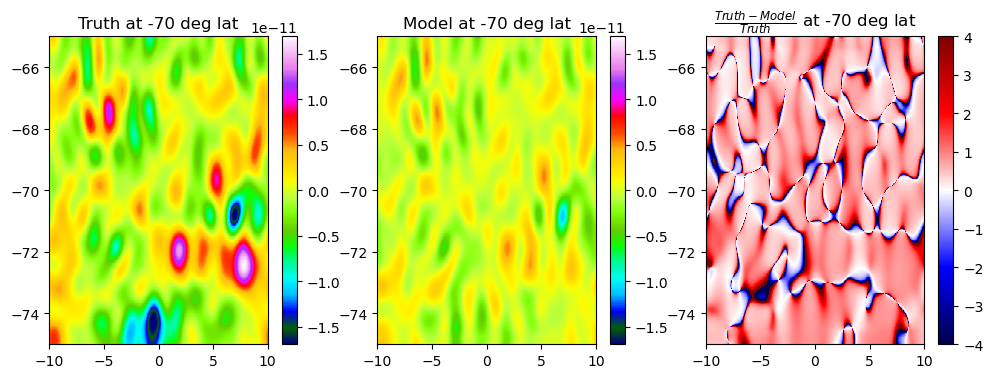

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

v = np.max(truth)
v2 = 4

n=0

x1,x2 = n,xlen-n
y1,y2 = n,ylen-n

cmap = plt.get_cmap('gist_ncar')
p = ax[0].pcolormesh(rad2deg(LON)[y1:y2, x1:x2], rad2deg(LAT)[y1:y2, x1:x2], truth[y1:y2, x1:x2], 
                   cmap=cmap, vmin=-v, vmax=v)
plt.colorbar(p, ax=ax[0])
ax[0].set_title('Truth at {0:2.0f} deg lat'.format(center_lat_inDeg))

p = ax[1].pcolormesh(rad2deg(LON)[y1:y2, x1:x2], rad2deg(LAT)[y1:y2, x1:x2], model2[y1:y2, x1:x2], 
                   cmap=cmap, vmin=-v, vmax=v)
plt.colorbar(p, ax=ax[1])
ax[1].set_title('Model at {0:3.0f} deg lat'.format(center_lat_inDeg))

p = ax[2].pcolormesh(rad2deg(LON)[y1:y2, x1:x2], rad2deg(LAT)[y1:y2, x1:x2], (truth[y1:y2, x1:x2] - model2[y1:y2, x1:x2])/truth[y1:y2, x1:x2], 
                   cmap='seismic', vmin=-v2, vmax=v2)
plt.colorbar(p, ax=ax[2])
ax[2].set_title(r'$\frac{Truth - Model}{Truth}$'+ ' at {0:3.0f} deg lat'.format(center_lat_inDeg))

print(truth[y1:y2, x1:x2].shape)
print(ylen, xlen, y1, y2)

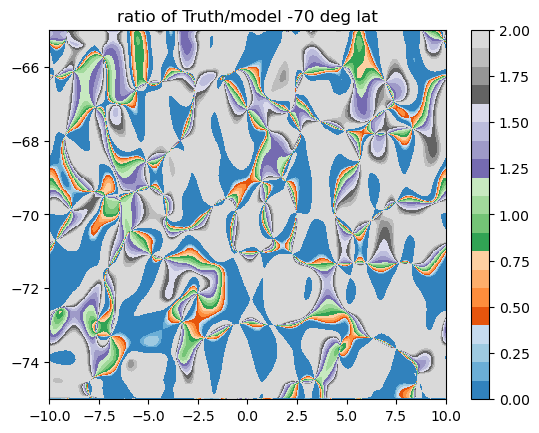

In [16]:
v=2
plt.pcolormesh(rad2deg(LON), rad2deg(LAT), truth/model2, cmap='tab20c', vmin =0, vmax=v) 
plt.title("ratio of Truth/model {0:3.0f} deg lat".format(center_lat_inDeg))
plt.colorbar()

In [17]:
dx_f1, dy_f1 = GetGradient(f1bar, dX, dY)
dx_f2, dy_f2 = GetGradient(f2bar, dX, dY)

In [18]:
cmap = plt.get_cmap('seismic')

nlevels = 20

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,12), sharex=True, sharey=True)
m = ax[0,0].contourf(X/1e3, Y/1e3, dx_f1, cmap = cmap, levels=nlevels)
ax[0,0].set_title('dx_f1bar')
plt.colorbar(m, ax=ax[0, 0])

m = ax[0,1].contourf(X/1e3, Y/1e3, dy_f1, cmap = cmap, levels=nlevels)
ax[0,1].set_title('dy_f1bar')
plt.colorbar(m, ax=ax[0, 1])

m = ax[1,0].contourf(X/1e3, Y/1e3, dx_f2, cmap = cmap, levels=nlevels)
ax[1,0].set_title('dx_f2bar')
plt.colorbar(m, ax=ax[1, 0])

m = ax[1,1].contourf(X/1e3, Y/1e3, dy_f2, cmap = cmap, levels=nlevels)
ax[1,1].set_title('dy_f2bar')
plt.colorbar(m, ax=ax[1, 1])

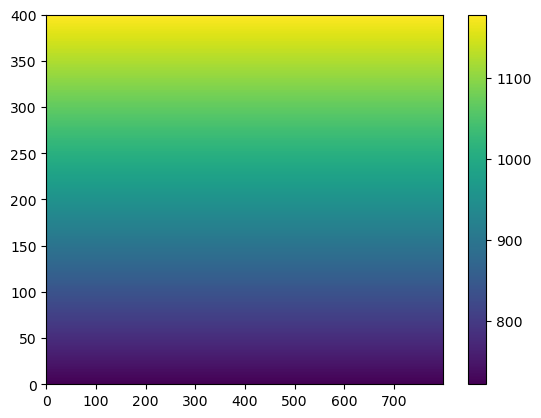

In [19]:
plt.pcolormesh(dX)
plt.colorbar()

2786.8402667815253


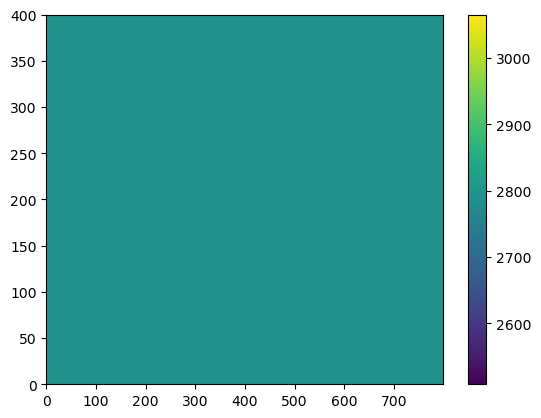

In [20]:
plt.pcolormesh(dY)
plt.colorbar()
print(np.mean(dY))